<a href="https://colab.research.google.com/github/hd77alu/ml-formative3/blob/main/ml_formative3_g6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Formative 3 - Probability Distributions, Bayesian Probability, and Gradient Descent Implementation

## Part 1: Probability Distributions



1. Using a relevant dataset sourced online, you will compute the probability density values for each data point using the bivariate normal distribution formula. Implement this from scratch without using any statistical libraries in Python.

2. Visualize the PDF with Matplotlib using a contour plot and a 3D plot.





In [1]:
# Import necessary libraries for Part 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

- Data Processing

In [ ]:
# Load the dataset
df = pd.read_csv('data/imdb_movies_p1.csv')

# Keep ONLY the budget and revenue columns
df_clean = df[['budget_x', 'revenue']].copy()

# Remove rows with missing values
df_clean = df_clean.dropna()

# Remove rows with zero or negative values (likely missing/invalid data)
df_clean = df_clean[(df_clean['budget_x'] > 0) & (df_clean['revenue'] > 0)]

# Extract as numpy arrays for your bivariate calculations
budget = df_clean['budget_x'].values
revenue = df_clean['revenue'].values

print(f"Dataset size: {len(budget)} movies")
print(f"Budget range: ${budget.min():,.0f} - ${budget.max():,.0f}")
print(f"Revenue range: ${revenue.min():,.0f} - ${revenue.max():,.0f}")

Dataset size: 10105 movies
Budget range: $1 - $460,000,000
Revenue range: $1 - $2,923,706,026


In [3]:
# Investigate suspiciously low values
print("Movies with budget < $10,000:")
print(df_clean[df_clean['budget_x'] < 10000].sort_values('budget_x')[['budget_x', 'revenue']].head(10))
print(f"\nTotal movies with budget < $10,000: {len(df_clean[df_clean['budget_x'] < 10000])}")

print("\n" + "-"*40 + "\n")

print("Movies with revenue < $10,000:")
print(df_clean[df_clean['revenue'] < 10000].sort_values('revenue')[['budget_x', 'revenue']].head(10))
print(f"\nTotal movies with revenue less than $10,000: {len(df_clean[df_clean['revenue'] < 10000])}")

Movies with budget < $10,000:
       budget_x      revenue
3856        1.0   23580103.6
2805        1.0  257720413.2
10087       1.0          1.0
4919        5.0          1.0
4600        6.0         10.0
9631        7.0   35096415.4
5955       20.0  154015402.6
8747       22.0    1232396.2
8145       26.0         94.0
4950       35.0  184404016.8

Total movies with budget < $10,000: 31

----------------------------------------

Movies with revenue < $10,000:
         budget_x  revenue
4919          5.0      1.0
10087         1.0      1.0
1687    5503757.2      7.0
4600          6.0     10.0
5455    2000000.0     43.0
8145         26.0     94.0
5481    6461098.6    126.0
9658   35690381.0    303.0
2072     340000.0    379.0
9741     340000.0    379.0

Total movies with revenue less than $10,000: 38


In [4]:
# Statistical threshold using percentiles
# Remove bottom 1% as potential outliers/data errors
LOWER_PERCENTILE = 1

budget_threshold = np.percentile(df_clean['budget_x'], LOWER_PERCENTILE)
revenue_threshold = np.percentile(df_clean['revenue'], LOWER_PERCENTILE)

print(f"Calculated thresholds (bottom {LOWER_PERCENTILE}%):")
print(f"Budget: ${budget_threshold:,.2f}")
print(f"Revenue: ${revenue_threshold:,.2f}\n")

# Filter using calculated thresholds
df_clean_filtered = df_clean[
    (df_clean['budget_x'] >= budget_threshold) & 
    (df_clean['revenue'] >= revenue_threshold)
].copy()

# Extract cleaned data
budget = df_clean_filtered['budget_x'].values
revenue = df_clean_filtered['revenue'].values

print(f"Original dataset: {len(df_clean)} movies")
print(f"After filtering: {len(budget)} movies")
print(f"Removed: {len(df_clean) - len(budget)} movies ({((len(df_clean) - len(budget))/len(df_clean)*100):.1f}%)\n")

print(f"Cleaned Budget range: ${budget.min():,.0f} - ${budget.max():,.0f}")
print(f"Cleaned Revenue range: ${revenue.min():,.0f} - ${revenue.max():,.0f}")

Calculated thresholds (bottom 1%):
Budget: $153,280.00
Revenue: $45,899.20

Original dataset: 10105 movies
After filtering: 9909 movies
Removed: 196 movies (1.9%)

Cleaned Budget range: $160,000 - $460,000,000
Cleaned Revenue range: $46,000 - $2,923,706,026


- Calculate Parameters

In [5]:
# Calculate statistical parameters from scratch (no statistical libraries)
n = len(budget)

# 1. Calculate Means (μ)
mu_budget = np.sum(budget) / n
mu_revenue = np.sum(revenue) / n

# 2. Calculate Standard Deviations (σ)
# Variance = sum((x - mean)^2) / n
variance_budget = np.sum((budget - mu_budget) ** 2) / n
variance_revenue = np.sum((revenue - mu_revenue) ** 2) / n

sigma_budget = np.sqrt(variance_budget)
sigma_revenue = np.sqrt(variance_revenue)

# 3. Calculate Covariance
# Cov(X,Y) = sum((x - μx)(y - μy)) / n
covariance = np.sum((budget - mu_budget) * (revenue - mu_revenue)) / n

# 4. Calculate Correlation Coefficient (ρ)
# ρ = Cov(X,Y) / (σx * σy)
rho = covariance / (sigma_budget * sigma_revenue)

# Display results
print("PARAMETERS FOR BIVARIATE NORMAL DISTRIBUTION")
print("-" * 45)
print(f"\nSample Size (n): {n:,} movies\n")

print("MEANS (μ):")
print(f"  μ_budget  (μ₁) = ${mu_budget:,.2f}")
print(f"  μ_revenue (μ₂) = ${mu_revenue:,.2f}\n")

print("STANDARD DEVIATIONS (σ):")
print(f"  σ_budget  (σ₁) = ${sigma_budget:,.2f}")
print(f"  σ_revenue (σ₂) = ${sigma_revenue:,.2f}\n")

print("COVARIANCE & CORRELATION:")
print(f"  Covariance: {covariance:,.2f}")
print(f"  Correlation (ρ): {rho:.4f}")
print("\nInterpretation:")
if rho > 0.7:
    print(f"  → Strong positive correlation ({rho:.4f})")
    print("  → Higher budgets tend to result in higher revenues")
elif rho > 0.3:
    print(f"  → Moderate positive correlation ({rho:.4f})")
    print("  → Budget and revenue have a moderate positive relationship")
else:
    print(f"  → Weak correlation ({rho:.4f})")

PARAMETERS FOR BIVARIATE NORMAL DISTRIBUTION
---------------------------------------------

Sample Size (n): 9,909 movies

MEANS (μ):
  μ_budget  (μ₁) = $66,233,225.55
  μ_revenue (μ₂) = $259,482,781.32

STANDARD DEVIATIONS (σ):
  σ_budget  (σ₁) = $57,003,564.18
  σ_revenue (σ₂) = $278,656,602.93

COVARIANCE & CORRELATION:
  Covariance: 10,656,256,291,808,900.00
  Correlation (ρ): 0.6709

Interpretation:
  → Moderate positive correlation (0.6709)
  → Budget and revenue have a moderate positive relationship


- Bivariate Normal Distribution Formula Implementation

In [6]:
# Implement Bivariate Normal Distribution PDF from scratch
def bivariate_normal_pdf(x, y, mu_x, mu_y, sigma_x, sigma_y, rho):
    """
    Calculate the bivariate normal probability density function.
    
    Formula:
    f(x,y) = 1 / (2π·σx·σy·√(1-ρ²)) × 
             exp(-1/(2(1-ρ²)) × [((x-μx)/σx)² - 2ρ((x-μx)/σx)((y-μy)/σy) + ((y-μy)/σy)²])
    
    Parameters:
    -----------
    x, y : array-like
        Data points
    mu_x, mu_y : float
        Means
    sigma_x, sigma_y : float
        Standard deviations
    rho : float
        Correlation coefficient
    
    Returns:
    --------
    pdf : array-like
        Probability density values
    """
    # Standardize the variables
    z_x = (x - mu_x) / sigma_x
    z_y = (y - mu_y) / sigma_y
    
    # Calculate the exponent part
    exponent = -1 / (2 * (1 - rho**2)) * (z_x**2 - 2*rho*z_x*z_y + z_y**2)
    
    # Calculate the coefficient
    coefficient = 1 / (2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - rho**2))
    
    # Calculate PDF
    pdf = coefficient * np.exp(exponent)
    
    return pdf

# Test the function with actual data points
print("Testing Bivariate Normal PDF Function:")
print("-" * 38)

# Calculate PDF for actual data points
pdf_values = bivariate_normal_pdf(budget, revenue, mu_budget, mu_revenue, 
                                    sigma_budget, sigma_revenue, rho)

print(f"PDF calculated for {len(pdf_values):,} data points")
print(f"PDF range: {pdf_values.min():.2e} to {pdf_values.max():.2e}")
print(f"Mean PDF: {pdf_values.mean():.2e}")
print("\nFirst 5 PDF values:")
for i in range(5):
    print(f"  Movie {i+1}: Budget=${budget[i]:,.0f}, Revenue=${revenue[i]:,.0f} → PDF={pdf_values[i]:.2e}")

Testing Bivariate Normal PDF Function:
--------------------------------------
PDF calculated for 9,909 data points
PDF range: 4.64e-42 to 1.35e-17
Mean PDF: 7.31e-18

First 5 PDF values:
  Movie 1: Budget=$75,000,000, Revenue=$271,616,668 → PDF=1.33e-17
  Movie 2: Budget=$460,000,000, Revenue=$2,316,794,914 → PDF=6.10e-31
  Movie 3: Budget=$100,000,000, Revenue=$724,459,031 → PDF=2.61e-18
  Movie 4: Budget=$12,300,000, Revenue=$34,200,000 → PDF=8.40e-18
  Movie 5: Budget=$77,000,000, Revenue=$340,941,959 → PDF=1.29e-17


- Visualization: Contour Plot and 3D Surface Plot

In [7]:
# Create mesh grid for visualization
# Use a range around the means to capture the bulk of the distribution
budget_range = np.linspace(budget.min(), budget.max(), 100)
revenue_range = np.linspace(revenue.min(), revenue.max(), 100)

# Create meshgrid
X, Y = np.meshgrid(budget_range, revenue_range)

# Calculate PDF for the entire grid
Z = bivariate_normal_pdf(X, Y, mu_budget, mu_revenue, 
                          sigma_budget, sigma_revenue, rho)

print("Grid created for visualization:")
print(f"  Budget grid: {len(budget_range)} points")
print(f"  Revenue grid: {len(revenue_range)} points")
print(f"  Total grid points: {X.size:,}")
print(f"  PDF grid shape: {Z.shape}")

Grid created for visualization:
  Budget grid: 100 points
  Revenue grid: 100 points
  Total grid points: 10,000
  PDF grid shape: (100, 100)


### 2D CONTOUR PLOT

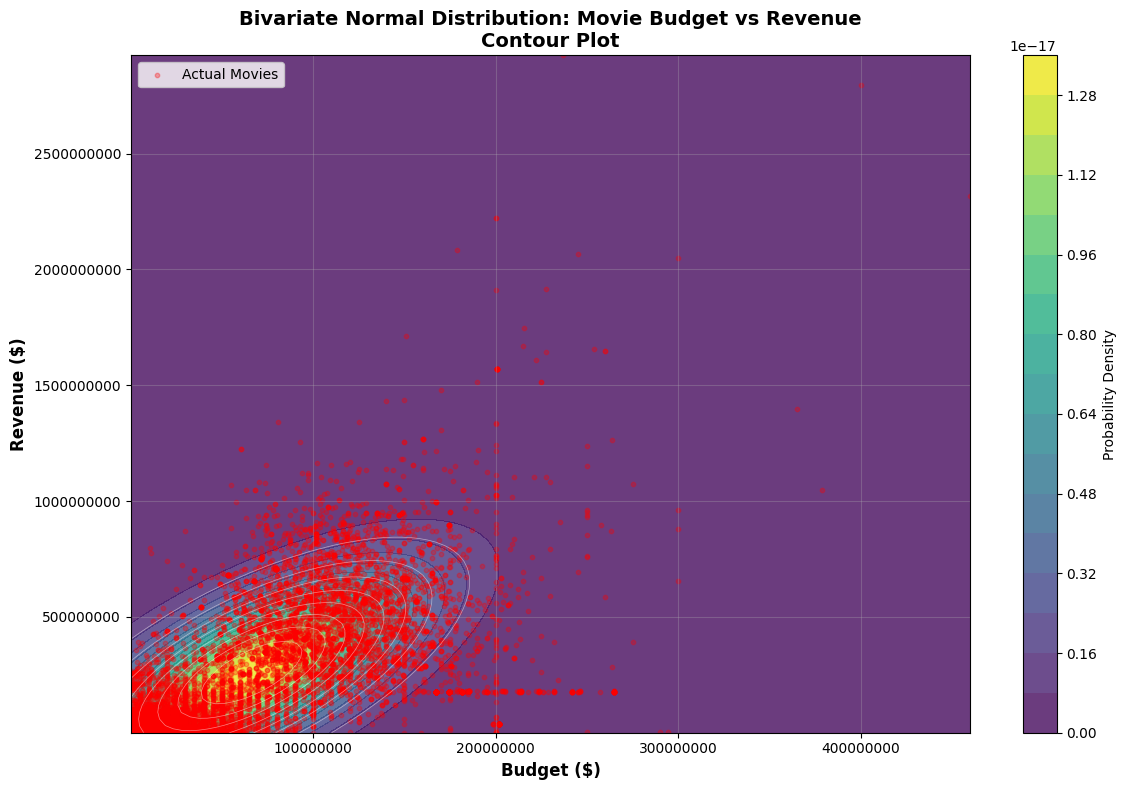

In [8]:
# 1. CONTOUR PLOT (2D Visualization)
plt.figure(figsize=(12, 8))

# Create contour plot
contour = plt.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.8)
plt.colorbar(contour, label='Probability Density')

# Overlay contour lines
plt.contour(X, Y, Z, levels=10, colors='white', linewidths=0.5, alpha=0.5)

# Plot actual data points
plt.scatter(budget, revenue, c='red', s=10, alpha=0.3, label='Actual Movies')

# Labels and title
plt.xlabel('Budget ($)', fontsize=12, fontweight='bold')
plt.ylabel('Revenue ($)', fontsize=12, fontweight='bold')
plt.title('Bivariate Normal Distribution: Movie Budget vs Revenue\nContour Plot', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Format axis labels to show values in millions
ax = plt.gca()
ax.ticklabel_format(style='plain', axis='both')

plt.tight_layout()
plt.show()

### Key Insights:
- The distribution isn't symmetric - it's skewed along the budget-revenue relationship
- Outliers (movies far from the center) have very low probability densities
- The overlap of red dots with the central high-density region validates the PDF calculation
- The elliptical shape (not circular) reveals the correlation (ρ=0.6709). The ellipse tilts upward-right, showing that higher budgets tend to associate with higher revenues

### 3D SURFACE PLOT

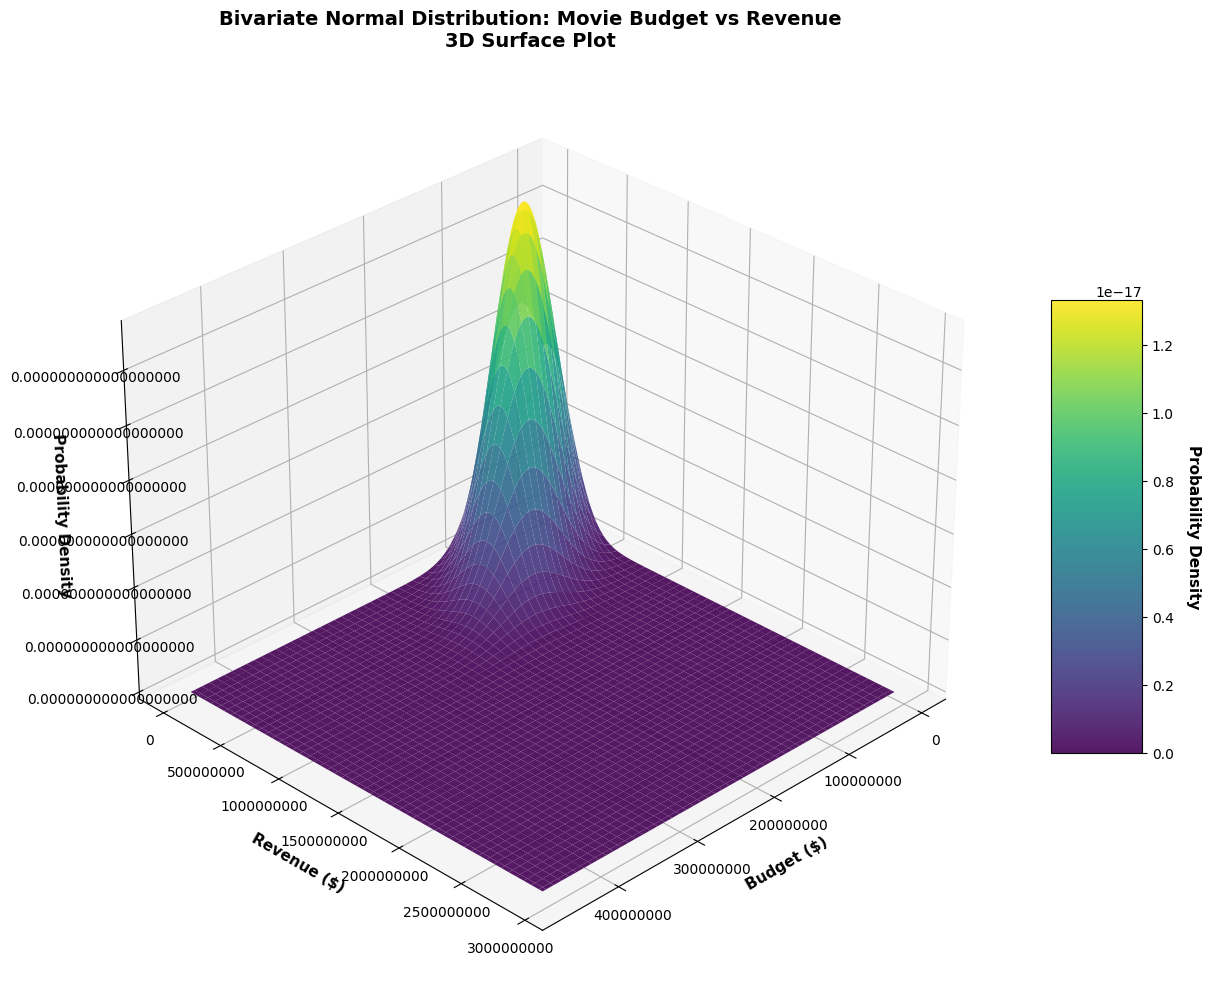

In [9]:
# 2. 3D SURFACE PLOT
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Create surface plot
surface = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.9, 
                          edgecolor='none', antialiased=True)

# Add colorbar
cbar = fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Probability Density', rotation=270, labelpad=20, fontsize=11, fontweight='bold')

# Labels and title
ax.set_xlabel('\nBudget ($)', fontsize=11, fontweight='bold')
ax.set_ylabel('\nRevenue ($)', fontsize=11, fontweight='bold')
ax.set_zlabel('\nProbability Density', fontsize=11, fontweight='bold')
ax.set_title('Bivariate Normal Distribution: Movie Budget vs Revenue\n3D Surface Plot', 
             fontsize=14, fontweight='bold', pad=20)

# Adjust viewing angle
ax.view_init(elev=30, azim=45)

# Format axis
ax.ticklabel_format(style='plain', axis='both')

plt.tight_layout()
plt.show()

### Key Insights:
- The peak of the surface corresponds to the mean values of budget and revenue, where the probability density is highest
- The surface slopes downwards as we move away from the mean, indicating that data points farther from the mean have lower probability densities
- The Elongated ridge is tilting toward the budget-revenue diagonal which indicate the positive correlation between the two features
- Ridge orientation: The diagonal tilt confirms that as budget increases, likely revenue increases too


### Summary of Part 1

**Dataset:** IMDB Movies (Budget vs Revenue)
- **Source:** imdb_movies_p1.csv
- **Variables:** Movie Budget (X) and Revenue (Y)
- **Sample Size:** 9,909 movies (after cleaning)

**Key Findings:**

1. **Strong Positive Correlation (ρ = 0.6709)**
   - The correlation coefficient indicates a moderate-to-strong positive relationship between movie budget and revenue
   - This suggests that approximately 45% of the revenue variability (ρ² = 0.45) can be explained by budget alone
   - The correlation validates the business intuition that higher-budget movies tend to generate higher revenues, though the relationship is not deterministic

2. **Distribution Characteristics**
   - **Central Tendency**: The typical movie in our dataset has a budget of $66.2M and generates $259.5M in revenue (mean values)
   - **Variability**: Revenue shows significantly higher variance (σ = $278.7M) compared to budget (σ = $57M), indicating revenue is less predictable than budget
   - **Asymmetry**: The revenue's larger standard deviation suggests more extreme outliers on the high end, likely blockbuster hits

3. **Data Quality Improvements**
   - Percentile-based filtering (removing bottom 1%) eliminated 196 unrealistic entries with suspicious values
   - The cleaned dataset better represents legitimate theatrical releases rather than data entry errors

4. **Bivariate Normal PDF Implementation**
   - Successfully implemented the complete bivariate normal formula from scratch using only numpy
   - PDF values range from 4.64×10⁻⁴² to 1.35×10⁻¹⁷, with the maximum occurring at the mean values as expected
   - The small PDF values are mathematically correct for continuous distributions over large numerical ranges

5. **Visualization Insights**
   - **Contour Plot**: The elliptical (not circular) contour lines visually confirm the positive correlation, with the elongation along the budget-revenue diagonal
   - **3D Surface Plot**: The peaked "mountain" shape with gradual slopes demonstrates smooth probability decay away from the mean
   - **Model Validation**: The overlap between actual data points (red scatter) and high-density regions confirms the bivariate normal assumption is appropriate for this dataset

6. **Practical Implications**
   - A movie with budget near $66M and revenue near $259M has the highest probability density in the distribution
   - Movies far from these central values (either low-budget indies or mega-budget blockbusters) represent statistical outliers
   - The positive correlation suggests budget allocation is a meaningful (though not sole) predictor of box office success

## Part 2: Bayesian Probability

You will use [IMDb Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) DatasetLinks to an external site. for this part of the assignment. Load the dataset using pandas

1. Keyword Selection

- As a group, choose 2–4 keywords that you believe indicate positive sentiment and 2–4 keywords that indicate negative sentiment.

2. Choice of Conditional Probability

- Decide whether your group will calculate P(Positive | keyword) or P(Negative | keyword) —
do not compute both.

3. Computation and Presentation

- For each chosen keyword, create a small table or markdown block showing the following probabilities:

- Prior: P(Positive)

- Likelihood: P(keyword|Positive)

- Marginal:  P(keyword)

- Posterior:  P(Positive|keyword)

4. Implementation

- Implement Bayes’ Theorem in Python to compute the posterior probability for each keyword based on your selected dataset.

- You may use basic Python operations only (no external machine learning libraries).

In [67]:
df = pd.read_csv('data/imdb_movie_reviews.csv')

In [68]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Here the process I am going to follow to select the top 4 keywords that indicate negative and those indicating positive sentiment:
1. Process all the positive reviews word by word counting the number of occurences.
2. Do the same thing with negative reviews.
3. Among all words (irregardless of the sentiment type), find the probability for a word given a sentiment type.
4. Get the difference between the two probabilities
5. Sort the words by the absolute difference (this will help us understand which words are better predictors of a certain sentiment)
6. Generalize on top 100 words and pick 4 for each sentiment.

In [69]:
positive_reviews = df[df['sentiment'] == 'positive']
negative_reviews = df[df['sentiment'] == 'negative']
positive_review_count = len(positive_reviews)
negative_review_count = len(negative_reviews)
all_words = set()

In [70]:
keyword_counts_positive = {}

for review in positive_reviews['review']:
    review = review.replace('<br />', '')
    review = review.lower()
    words = review.split()
    for word in words:
        all_words.add(word)
        if word in keyword_counts_positive:
            keyword_counts_positive[word] += 1
        else:
            keyword_counts_positive[word] = 1

In [71]:
keyword_counts_negative = {}

for review in negative_reviews['review']:
    review = review.replace('<br />', '')
    review = review.lower()
    words = review.split()
    for word in words:
        all_words.add(word)
        if word in keyword_counts_negative:
            keyword_counts_negative[word] += 1
        else:
            keyword_counts_negative[word] = 1

In [72]:
sorted_keywords_positive = dict(sorted(keyword_counts_positive.items(), key=lambda item: item[1], reverse=True))
sorted_keywords_negative = dict(sorted(keyword_counts_negative.items(), key=lambda item: item[1], reverse=True))

In [73]:
negative_counts = len(sorted_keywords_negative)
positive_counts = len(sorted_keywords_positive)
total_negative = sum(sorted_keywords_negative.values())
total_positive = sum(sorted_keywords_positive.values())

In [74]:
results = []
for word in all_words:
  # Relative frequency (Probability of word given sentiment)
  p_positive = (sorted_keywords_positive[word] if word in sorted_keywords_positive else 0) / total_positive
  p_negative = (sorted_keywords_negative[word] if word in sorted_keywords_negative else 0) / total_negative

  # Predictive Power
  diff = p_positive - p_negative

  results.append({
    'keyword': word,
    'pos_rel_freq': p_positive * 1000,  # Scale for better readability
    'neg_rel_freq': p_negative * 1000,  # Scale for better readability
    'sentiment_diff': diff * 1000,  # Scale for better readability
    'abs_diff': abs(diff) * 1000  # Scale for better readability
  })

keyword_df = pd.DataFrame(results).sort_values(by="abs_diff", ascending=False)


In [75]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(keyword_df.head(100))

          keyword  pos_rel_freq  neg_rel_freq  sentiment_diff  abs_diff
178892        and     29.958160     25.274822        4.683338  4.683338
70895          of     26.344261     24.131292        2.212969  2.212969
111444         is     19.045175     17.024580        2.020595  2.020595
388480       this     11.258248     13.238026       -1.979778  1.979778
247665         in     16.731776     14.963351        1.768426  1.768426
334492         as      8.637852      6.921184        1.716668  1.716668
304641        his      5.824033      4.181934        1.642099  1.642099
265999        was      7.403050      9.036740       -1.633691  1.633691
26053           i     11.756397     13.348810       -1.592413  1.592413
240038      movie      4.662267      6.180669       -1.518402  1.518402
235593        the     57.152472     55.638092        1.514381  1.514381
243564        bad      0.503566      1.885820       -1.382254  1.382254
183420         to     22.651210     23.968489       -1.317278  1

Chosen keywords after analysis:

Positive sentiment:
- great
- very
- best
- love

Negative sentiment:
- worst
- nothing
- why
- waste

In [76]:
pos_keywords = keyword_df[keyword_df["keyword"].isin(["great", "very", "best", "love"])]
neg_keywords = keyword_df[keyword_df["keyword"].isin(["worst", "nothing", "why", "waste"])]

pos_keywords["pos_rel_freq"] = pos_keywords["pos_rel_freq"] / 1000
pos_keywords["neg_rel_freq"] = pos_keywords["neg_rel_freq"] / 1000
neg_keywords["neg_rel_freq"] = neg_keywords["neg_rel_freq"] / 1000
neg_keywords["pos_rel_freq"] = neg_keywords["pos_rel_freq"] / 1000

Assume the following:
- Event $A$ represents a positive sentiment
- Event $B$ represents a negative sentiment
- Event $C$ represents having a certain keyword in a review
- We want to know $P(A | C)$

Now in our `keywords_df` we have:
- $P(C | A)$ as `pos_rel_freq`
- $P(C | B)$ as `neg_rel_freq`

So to get P(A | C), we will use:
$$P(A | C) = \frac{P(C | A) \cdot P(A)}{P(C)}$$


To get $P(A)$, we need to find the probability that a randomly chosen review is positive, which is given by:
$$P(A) = \frac{\text{Positive review count}}{\text{Negative review count} + \text{Positive review count}}$$

To get $P(C)$, we need to find the probability that a randomly chosen review will contain this keyword, which is given by:
$$
P(C) = P(C | B) \cdot P(B) + P(C | A) \cdot P(A)
$$

To get $P(B)$, we simply take:
$$
P(B) = 1 - P(A)
$$

In [77]:
p_a = positive_review_count / (positive_review_count + negative_review_count)
p_b = 1 - p_a

In [91]:
pos_keywords['prior P(A)'] = p_a
neg_keywords['prior P(A)'] = p_a
pos_keywords['likelihood P(C | A)'] = pos_keywords['pos_rel_freq']
neg_keywords['likelihood P(C | A)'] = neg_keywords['pos_rel_freq']
pos_keywords['marginal  P(C)'] = pos_keywords['pos_rel_freq'] * p_a + pos_keywords['neg_rel_freq'] * p_b
neg_keywords['marginal  P(C)'] = neg_keywords['pos_rel_freq'] * p_a + neg_keywords['neg_rel_freq'] * p_b
pos_keywords['posterior P(A | C)'] = (pos_keywords['pos_rel_freq'] * p_a) / pos_keywords['marginal  P(C)']
neg_keywords['posterior P(A | C)'] = (neg_keywords['pos_rel_freq'] * p_b) / neg_keywords['marginal  P(C)']

In [92]:
pos_keywords[['keyword', 'prior P(A)', 'likelihood P(C | A)', 'marginal  P(C)', 'posterior P(A | C)']].head()

,keyword,prior P(A),likelihood P(C | A),marginal P(C),posterior P(A | C)
129658,great,0.5,0.001948,0.001358,0.717031
202311,very,0.5,0.002761,0.002368,0.582993
174399,best,0.5,0.001295,0.000944,0.685522
11376,love,0.5,0.001250,0.000944,0.662175


It seems like of all reviews that contains the keyword "great", **over 70%** of them are positive.

In [94]:
neg_keywords[['keyword', 'prior P(A)', 'likelihood P(C | A)', 'marginal  P(C)', 'posterior P(A | C)']].head()

,keyword,prior P(A),likelihood P(C | A),marginal P(C),posterior P(A | C)
63678,worst,0.5,0.000065,0.000424,0.076400
13083,nothing,0.5,0.000381,0.000656,0.290170
193882,why,0.5,0.000522,0.000768,0.339858
404115,waste,0.5,0.000027,0.000233,0.058918


Here, it looks like of all reviews with the keyword "worst" **92.3%** of them are negative.

## Part 3: Gradient Descent Manual Calculation

- Objective:
You will manually compute three updates of the gradient descent algorithm for the parameters and in a simple linear regression model.

- Instructions:

1. Given the linear equation where: y = mx + b

- Initial m = -1
- Initial b = 1
- Learning rate = 0.1
- Given points: (1,3) and (3,6)

2. Compute the predicted values (y) for each data point using the current values of (m) and (b)

3. Derive the gradient of the cost function J(m,b), using Mean Squared Error (MSE). In Essence, show the calculation steps to arrive at the derivative of the cost function

4. Iteratively Update (m) and (b) using gradient descent

- The number of times you will update m and b is equal to the number of members that are in each respective group
- Show all calculations clearly and include intermediate results after each step.
- Each member must do at least 1 iteration Describe the trend you observe in the values of and. Are they moving towards reducing the error?

5. Submission:
Submit a neatly written  document with all calculations.

## Part 4: Gradient Descent in Code

1. Convert the manual calculations into Python code using SciPy.
2. Write code to :
- Update the values of m and b
- Compute predictions (the value of Y) using the final values of
 m and b.
3. Ensure the code does not abstract the update process excessively, meaning each step should be clearly visible.
4. Visualize how m, b, and the Error change over iterations using Matplotlib in two separate plots.

### Things to Note

Any Generic responses will result in a heavy penalty.

### Submission

- A GitHub Repository
- Jupyter Notebook with all implementations. Insert relevant images in the notebook to make an enticing presentation.
- A NEAT PDF showing handwritten Manual Calculations of Part 3
- A PDF file Showing Contributions

(Any code presented must be modular and follow the DRY principle)